# Start Here

In the cell below are a few functions that help with plotting data using `matplotlib`. Run the cell to define the functions.

In [40]:
%matplotlib inline
import os
os.environ["PROJ_LIB"] = "/usr/local/anaconda3/share/proj"
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
# from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs #added by B Clark because Basemap is deprecated
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import types
import math
import sys
import time
import requests
from datetime import datetime
import itertools
from shapely.geometry import box
from pprint import pprint, pformat
import textwrap
import warnings
warnings.filterwarnings("ignore")

# ISO-8601 date format
dt_format = "%Y-%m-%dT%H:%M:%SZ"

def show_plot(x_data, y_data, x_label=None, y_label=None, title=None):
    """
    Display a simple line plot.
    
    :param x_data: Numpy array containing data for the X axis
    :param y_data: Numpy array containing data for the Y axis
    :param x_label: Label applied to X axis
    :param y_label: Label applied to Y axis
    """
    plt.figure(figsize=(6,3), dpi=100)
    plt.plot([datetime.fromtimestamp(x_val) for x_val in x_data], y_data, 'b-', marker='|', markersize=2.0, mfc='b')
    plt.grid(b=True, which='major', color='k', linestyle='-')
    if title is not None:
        plt.title(title)
    if x_label is not None:
        plt.xlabel(x_label)
    if y_label is not None:
        plt.ylabel (y_label)
    plt.xticks(rotation=45)
    ts_range = x_data[-1] - x_data[0]

    # Define the time formatting
    if ts_range > 189216000: # 6 years
        dtFmt = mdates.DateFormatter('%Y')
    elif ts_range > 15552000: # 6 months
        dtFmt = mdates.DateFormatter('%b %Y')
    else: # < 6 months
        dtFmt = mdates.DateFormatter('%b %-d, %Y')

    plt.gca().xaxis.set_major_formatter(dtFmt)
    plt.show()
    
def plot_box(bbox):
    """
    Display a Green bounding box on an image of the blue marble.
    
    :param bbox: Shapely Polygon that defines the bounding box to display
    """
    min_lon, min_lat, max_lon, max_lat = bbox.bounds
    import matplotlib.pyplot as plt1
    from matplotlib.patches import Polygon
    from mpl_toolkits.basemap import Basemap

    map = Basemap()
    map.bluemarble(scale=0.5)
    poly = Polygon([(min_lon,min_lat),(min_lon,max_lat),(max_lon,max_lat),(max_lon,min_lat)],
                   facecolor=(0,0,0,0.0),edgecolor='green',linewidth=2)
    plt1.gca().add_patch(poly)
    plt1.gcf().set_size_inches(10,15)
    
    plt1.show()
    
def show_plot_two_series(x_data_a, x_data_b, y_data_a, y_data_b, x_label, 
                         y_label_a, y_label_b, series_a_label, series_b_label):
    """
    Display a line plot of two series
    
    :param x_data_a: Numpy array containing data for the Series A X axis
    :param x_data_b: Numpy array containing data for the Series B X axis
    :param y_data_a: Numpy array containing data for the Series A Y axis
    :param y_data_b: Numpy array containing data for the Series B Y axis
    :param x_label: Label applied to X axis
    :param y_label_a: Label applied to Y axis for Series A
    :param y_label_b: Label applied to Y axis for Series B
    :param series_a_label: Name of Series A
    :param series_b_label: Name of Series B
    """
    fig, ax1 = plt.subplots(figsize=(10,5), dpi=100)
    series_a, = ax1.plot(x_data_a, y_data_a, 'b-', marker='|', markersize=2.0, mfc='b', label=series_a_label)
    ax1.set_ylabel(y_label_a, color='b')
    ax1.tick_params('y', colors='b')
    ax1.set_ylim(min(0, *y_data_a), max(y_data_a)+.1*max(y_data_a))
    ax1.set_xlabel(x_label)
    
    ax2 = ax1.twinx()
    series_b, = ax2.plot(x_data_b, y_data_b, 'r-', marker='|', markersize=2.0, mfc='r', label=series_b_label)
    ax2.set_ylabel(y_label_b, color='r')
    ax2.set_ylim(min(0, *y_data_b), max(y_data_b)+.1*max(y_data_b))
    ax2.tick_params('y', colors='r')
    
    plt.grid(b=True, which='major', color='k', linestyle='-')
    plt.legend(handles=(series_a, series_b), bbox_to_anchor=(1.1, 1), loc=2, borderaxespad=0.)
    plt.show()

def roundBorders(borders, borderSlop=10.):
    b0 = roundBorder(borders[0], 'down', borderSlop,   0.)
    b1 = roundBorder(borders[1], 'down', borderSlop, -90.)
    b2 = roundBorder(borders[2],   'up', borderSlop, 360.)
    b3 = roundBorder(borders[3],   'up', borderSlop,  90.)
    return [b0, b1, b2, b3]

def roundBorder(val, direction, step, end):
    if direction == 'up':
        rounder = math.ceil
        slop = step
    else:
        rounder = math.floor
        slop = -step
###    v = rounder(val/step) * step + slop                                      
    v = rounder(val/step) * step
    if abs(v - end) < step+1.: v = end
    return v

def normalizeLon(lon):
    if lon < 0.: return lon + 360.
    if lon > 360.: return lon - 360.
    return lon

def normalizeLons(lons):
    return np.array([normalizeLon(lon) for lon in lons])

def ensureItems(d1, d2):
    for key in d2.keys():
        if key not in d1: d1[key] = d2[key]

CmdOptions = {'MCommand':  ['title', 'xlabel', 'ylabel',  'xlim', 'ylim', 'show\
'],
   	      'plot':      ['label', 'linewidth', 'legend', 'axis'],
              'map.plot':  ['label', 'linewidth', 'axis'],
              'map.scatter':  ['norm', 'alpha', 'linewidths', 'faceted', 'hold'\
],
              'savefig':   ['dpi', 'orientation']
              }

def die(*s):   warn('Error,',  *s); sys.exit()
    
def evalKeywordCmds(options, cmdOptions=CmdOptions):
    for option in options:
        if option in cmdOptions['MCommand']:
            args = options[option]
            if args:
                if args is True:
                    args = ''
                else:
                    args = "'" + args + "'"
                if option in cmdOptions:
                    args += dict2kwargs( validCmdOptions(options, cmdOptions[option]) )
                try:
                    eval('plt.' + option + '(%s)' % args)
                except:
                    die('failed eval of keyword command option failed: %s=%s' % (option, args))

def validCmdOptions(options, cmd, possibleOptions=CmdOptions):
    return dict([(option, options[option]) for option in options.keys()
                    if option in possibleOptions[cmd]])

def dict2kwargs(d):
    args = [',%s=%s' % (kw, d[kw]) for kw in d]
    return ', '.join(args)

def imageMap(lons, lats, vals, vmin=None, vmax=None, 
             imageWidth=None, imageHeight=None, outFile=None,
             projection='cyl', cmap=plt.cm.jet, logColors=False, makeFigure=False,
             borders=[0., -90., 360., 90.], autoBorders=True, borderSlop=10.,
             meridians=[0, 360, 60], parallels=[-60, 90, 30], title='', normalizeLongs=True,
             **options):
    if normalizeLongs:
        lons = normalizeLons(lons)
    if vmin == 'auto': vmin = None
    if vmax == 'auto': vmax = None
    if imageWidth is not None: makeFigure = True
    if projection is None or projection == '': projection = 'cyl'
    if cmap is None or cmap == '': cmap = plt.cm.jet
    #if isinstance(cmap, types.StringType) and cmap != '':
    if isinstance(cmap, str) and cmap != '':
        try:
            cmap = eval('plt.cm.' + cmap)
        except:
            cmap = plt.cm.jet

    ensureItems(options, { \
                     'title': title, 'dpi': 100,
                     'imageWidth': imageWidth or 1024, 'imageHeight': imageHeight or 768})
    if autoBorders:
        borders = [min(lons), min(lats), max(lons), max(lats)]
        borders = roundBorders(borders, borderSlop)

    #m = Basemap(borders[0], borders[1], borders[2], borders[3], \
    #            projection=projection, lon_0=np.average([lons[0], lons[-1]]))

    if makeFigure:
        dpi = float(options['dpi'])
        width = float(imageWidth) / dpi
        height = width
        #if imageHeight is None:
        #    height = width * m.aspect
        #else:
        #    height = float(imageHeight) / dpi
        plt.figure(figsize=(width,height)).add_axes([0.1,0.1,0.8,0.8], frameon
=True)
        m = plt.axes(projection=ccrs.PlateCarree())
        #m.set_extent([meridians[0], meridians[1], parallels[0], parallels[1]],
        #             crs=ccrs.PlateCarree())
        gl = m.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                         linewidth=2, color='gray', alpha=0.5, linestyle='--')
        gl.xlabels_top = False
        gl.ylabels_left = True
        gl.ylabels_right = False
        gl.xlines = True
        gl.ylines = True
        gl.xlocator = mticker.FixedLocator(np.arange(meridians[0], meridians[1]+meridians[2], meridians[2]))
        gl.ylocator = mticker.FixedLocator(np.arange(parallels[0], parallels[1]+parallels[2], parallels[2]))
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 12, 'color': 'black'}
        gl.ylabel_style = {'size': 12, 'color': 'black'}
        
    if vmin is not None or vmax is not None: 
        if vmin is None:
            vmin = np.min(vals)
        else:
            vmin = float(vmin)
        if vmax is None:
            vmax = np.max(vals)
        else:
            vmax = float(vmax)
        vrange = (vmax - vmin) / 255.
        levels = np.arange(vmin, vmax, vrange/30.)
    else:
        levels = 30

    if logColors:
        norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)
    else:
        norm = None
    # x, y = m(*np.meshgrid(lons,lats))
    x, y = np.meshgrid(lons,lats)
    c = m.contourf(x, y, vals, levels, cmap=cmap, colors=None, norm=norm)
    # m.drawcoastlines()
    m.coastlines()
    #m.drawmeridians(range(meridians[0], meridians[1], meridians[2]), labels=[0,0,0,1])
    #m.drawparallels(range(parallels[0], parallels[1], parallels[2]), labels=[1,1,1,1])
    plt.colorbar(c, shrink=0.6)
    evalKeywordCmds(options)
    if outFile:
        plt.savefig(outFile, **validCmdOptions(options, 'savefig'))
    
def arr2d_from_json(js, var_name):
    return np.array([[js[i][j][var_name] for j in range(len(js[0]))] for i in range(len(js))])

def arr1d_from_json(js, var_name):
    return np.array([js[i][var_name] for i in range(len(js))])

def plot_map(map, val_key="mean", cnt_key="cnt", lon_key="lon", lat_key="lat", fill=-9999, grid_line_sep=10,
             border_slop=1, log_colors=False, title='', vmin=None, vmax=None, 
             normalize_lons=False, image_width=1000, **options):
    # Parse values, longitudes and latitudes from JSON response.
    vals = arr2d_from_json(map, val_key)
    cnts = arr2d_from_json(map, cnt_key)
    lons = arr1d_from_json(map[0], lon_key)
    lats = arr1d_from_json([map[i][0] for i in range(len(map))], lat_key)
    
    # If cnt is 0, set value to fill
    vals[cnts==0] = fill
    
    # Plot time time-averaged map as an image.
    print("Creating plot of the results.")
    print("This will take a minute.  Please wait...")
    min_val = np.min(vals[vals != fill])
    if vmin is None:
        vmin = min_val
    max_val = np.max(vals[vals != fill])
    if vmax is None:
        vmax = max_val
    min_lon = math.floor(np.min(lons)) - grid_line_sep
    max_lon = math.ceil(np.max(lons))
    min_lat = math.floor(np.min(lats)) - grid_line_sep
    max_lat = math.ceil(np.max(lats))
    imageMap(lons, lats, vals, imageWidth=image_width, vmin=vmin, vmax=vmax, logColors=log_colors,
             meridians=[min_lon, max_lon, grid_line_sep], 
             parallels=[min_lat, max_lat, grid_line_sep], borderSlop=border_slop, 
             title=title, normalizeLongs=normalize_lons, **options)
    
def ts_plot(dataset, ts_json, t_name='time', val_name='mean', 
            title='', units=''):
    t = np.array([ts[0][t_name] for ts in ts_json["data"]])
    vals = np.array([ts[0][val_name] for ts in ts_json["data"]])
    show_plot(t, vals, title=textwrap.fill(title,64),
              y_label=textwrap.fill(units,32))

def plot_hovmoller(hm, time_key="time", val_key="mean",
                   coord_series_key="lats", coord_point_key="latitude",
                   coord_axis_vert=True, fill=-9999.,
                   hovfig=None, subplot=111, add_color_bar=True):
    times = [d[time_key] for d in hm]
    times = mdates.epoch2num(times)
    coords = [[d[coord_point_key] for d in hvals[coord_series_key]]
               for hvals in hm]
    coords_flat = np.array(sorted(list(set(itertools.chain(*coords)))))
    coords_delta = np.median(coords_flat[1:] - coords_flat[:-1])
    coords_min = np.amin(coords_flat)
    coords_max = np.amax(coords_flat)
    vals_fill = np.full((len(hm),len(coords_flat)), fill, dtype=np.float64)
    t_ind = 0
    for hvals in hm:
        cur_vals = np.array([d[val_key] for d in hvals[coord_series_key]])
        coords = np.array([d[coord_point_key] for d in hvals[coord_series_key]])
        coords_inds = np.round((coords - coords_min) /
                               coords_delta).astype(int)
        vals_fill[t_ind, coords_inds] = cur_vals
        t_ind += 1
    vals = np.ma.array(data=vals_fill, mask=vals_fill == fill)
    extent = [np.min(times), np.max(times), coords_min, coords_max]
    dtFmt = mdates.DateFormatter('%b %Y') # define the formatting
    if hovfig is None:
        fig = plt.figure(figsize=(16,6))
    else:
        fig = hovfig
    ax = fig.add_subplot(subplot)
    if coord_axis_vert:
        vals = np.transpose(vals)
        ax.xaxis.set_major_formatter(dtFmt)
        ax.set_ylabel(coord_point_key)
        plt.xticks(rotation=45)
    else:
        extent = [extent[2], extent[3], extent[0], extent[1]]
        ax.yaxis.set_major_formatter(dtFmt)
        ax.set_xlabel(coord_point_key)
    cax = ax.imshow(vals, origin='lower', extent=extent)
    ax.set_aspect('auto')
    if add_color_bar:
        fig.colorbar(cax, orientation='vertical')
    return fig

def compute_ts_and_tam_no_plot(dataset, bbox, start_time, end_time, base_url="localhost",
                               seasonal_filter="false"):
    url_params = 'ds={}&minLon={}&minLat={}&maxLon={}&maxLat={}&startTime={}&endTime={}'.\
        format(dataset, *bbox.bounds, 
               start_time.strftime(dt_format), end_time.strftime(dt_format))
    ts_url = '{}/timeSeriesSpark?{}&seasonalFilter={}'.format(base_url, url_params,
                                                              seasonal_filter)
    tam_url = '{}/timeAvgMapSpark?{}'.format(base_url, url_params)

    # Display some information about the job
    print(ts_url); print()
    print(tam_url); print()

    # Query SDAP to compute the time series
    print("Computing time series...")
    start = time.perf_counter()
    ts_json = requests.get(ts_url, verify=False).json()
    print("Area-averaged time series took {} seconds".format(time.perf_counter() - start))
    print()
    
    # Query SDAP to compute the time averaged map
    print("Computing time averaged map...")
    start = time.perf_counter()
    tam_json = requests.get(tam_url, verify=False).json()
    print("Time averaged map took {} seconds".format(time.perf_counter() - start))
    return ts_json, tam_json

def compute_ts_and_tam(dataset, bbox, start_time, end_time, base_url="localhost",
                       seasonal_filter="false", title='', grid_line_sep=5,
                       units=None, log_colors=False, normalize_lons=False, **options):
    ts_json, tam_json = compute_ts_and_tam_no_plot(dataset, bbox, start_time, end_time,
                                                   base_url=base_url,
                                                   seasonal_filter=seasonal_filter)
    print()
    print("Plot of area-average time series:")
    ts_plot(dataset, ts_json, val_name='mean', title=title, units=units)
    if seasonal_filter == "true":
        print("Plot of time series of difference with climatology:")
        ts_plot(dataset, ts_json, val_name='meanSeasonal',
                title=title, units=units)
        print()
    
    # Query SDAP to compute the time averaged map
    tam = tam_json["data"]
    plot_map(tam, log_colors=log_colors, grid_line_sep=grid_line_sep, title=title, 
             normalize_lons=normalize_lons, **options)

def show_sdap_json(j, nh=20, nt=10):
    out_str = pformat(j)
    for line in out_str.splitlines()[:nh]:
        print(line)
    print("\t\t.\n"*3)
    for line in out_str.splitlines()[-nt:]:
        print(line)

print('Done with plotting setup.')

Done with plotting setup.


# Science Data Analytics Platform (SDAP)
SDAP (https://sdap.apache.org/) provides advanced analytics capabilities to support the NASA Advanced Information Systems Technology (AIST) Program objectives for New Observing Strategies (NOS) and Analytic Collaborative Frameworks (ACF) (ref: Advanced Information Systems Technology (AIST) New Observing Strategies (NOS) 2021 Workshop
Summary Report, https://esto.nasa.gov/wp-content/uploads/2021/02/AIST-NOS-Workshop-Report.pdf).  

This notebook is a demonstration of how SDAP can be used with relevant datasets for rapid data subsetting and application of analytics algorithms such as area-averaged time series and time averaged map.  In this demonstration, an SDAP cloud computing deployment on Amazon Web Services (AWS, https://aws.amazon.com/) is used for analytics with datasets related to methane emissions.

SDAP provides web service endpoints for each analytic algorithm that can be accessed in a web browser or from a variety of programming languages.  This notebook demonstrates the Python API to access SDAP.

## Demonstration Setup

In the cell below, we specify the location of the SDAP deployments to use, a dataset to be used, the bounding box for an area of interest, and a time range for analysis.

In [2]:
# AWS Deployment for the M2AF project.
base_url = "https://methane-sdap-sit.jpl.nasa.gov/nexus"
print("Base URL set to {}".format(base_url))

# Define bounding box and time period for analysis
min_lon = -118.9; max_lon = -116.5
min_lat = 33.4; max_lat = 34.8
bbox = box(min_lon, min_lat, max_lon, max_lat)
start_time = datetime(2016, 1, 1)
end_time = datetime(2016, 12, 24)

# Specify the SDAP name of the dataset
dataset = "M2AF_REGIONAL_LABASIN_CH4_fluxes"

print("Selected dataset {}, spatial region {}, and time range {} to {}.".
      format(dataset, bbox, start_time, end_time))

Base URL set to https://methane-sdap-sit.jpl.nasa.gov/nexus
Selected dataset M2AF_REGIONAL_LABASIN_CH4_fluxes, spatial region POLYGON ((-116.5 33.4, -116.5 34.8, -118.9 34.8, -118.9 33.4, -116.5 33.4)), and time range 2016-01-01 00:00:00 to 2016-12-24 00:00:00.


# Cloud Analytics
## Data Inventory
We begin by querying the SDAP NEXUS list end point to examine what data are available in this
instantiation of SDAP. This can be done with the `nexuscli` module just imported, or by querying
the SDAP NEXUS `/list` web service end point.   We will do the latter now.

In [3]:
def get_sdap_inv(base_url):
    url = '{}/list'.format(base_url)
    print("Web Service Endpoint:"); print(url);
    res = requests.get(url, verify=False).json()
    pprint(res)
    
get_sdap_inv(base_url)

Web Service Endpoint:
https://methane-sdap-sit.jpl.nasa.gov/nexus/list
[{'end': 1514764800.0,
  'iso_end': '2018-01-01T00:00:00+0000',
  'iso_start': '2018-01-01T00:00:00+0000',
  'shortName': 'M2AF_GLOBAL_COAL_CH4_emission',
  'start': 1514764800.0,
  'tileCount': 72,
  'title': 'M2AF_GLOBAL_COAL_CH4_emission'},
 {'end': 1514764800.0,
  'iso_end': '2018-01-01T00:00:00+0000',
  'iso_start': '2018-01-01T00:00:00+0000',
  'shortName': 'M2AF_GLOBAL_FARM_CH4_emission',
  'start': 1514764800.0,
  'tileCount': 72,
  'title': 'M2AF_GLOBAL_FARM_CH4_emission'},
 {'end': 1514764800.0,
  'iso_end': '2018-01-01T00:00:00+0000',
  'iso_start': '2018-01-01T00:00:00+0000',
  'shortName': 'M2AF_GLOBAL_FIRE_CH4_emission',
  'start': 1514764800.0,
  'tileCount': 72,
  'title': 'M2AF_GLOBAL_FIRE_CH4_emission'},
 {'end': 1514764800.0,
  'iso_end': '2018-01-01T00:00:00+0000',
  'iso_start': '2018-01-01T00:00:00+0000',
  'shortName': 'M2AF_GLOBAL_GAS_CH4_emission',
  'start': 1514764800.0,
  'tileCount': 72,

## Area-Averaged Time Series
Next we will make a simple web service call to the SDAP /timeSeriesSpark endpoint.  This can also be done in a web browser or a variety of programming languages.

In [4]:
# Compute time series using the SDAP/NEXUS web/HTTP interface
#
# Construct the URL
url = '{}/timeSeriesSpark?ds={}&minLon={}&minLat={}&maxLon={}&maxLat={}&startTime={}&endTime={}'.\
    format(base_url, dataset, *bbox.bounds, 
           start_time.strftime(dt_format), end_time.strftime(dt_format))

# Display some information about the job
print(url); print()

# Query SDAP to compute the time averaged map
print("Waiting for response from SDAP on AWS...")
start = time.perf_counter()
ts_json = requests.get(url, verify=False).json()
print("Time series took {} seconds".format(time.perf_counter() - start))

https://methane-sdap-sit.jpl.nasa.gov/nexus/timeSeriesSpark?ds=M2AF_REGIONAL_LABASIN_CH4_fluxes&minLon=-118.9&minLat=33.4&maxLon=-116.5&maxLat=34.8&startTime=2016-01-01T00:00:00Z&endTime=2016-12-24T00:00:00Z

Waiting for response from SDAP on AWS...
Time series took 2.421654294943437 seconds


### JSON response
The SDAP web service calls return the result in `JSON`, a standard web services data
interchange format.  This makes it easy for another web service component to "consume" the SDAP output.
Let's view the JSON response.  It is long, so we'll show just the first few time values.|

In [5]:
show_sdap_json(ts_json, nh=33, nt=10)

{'data': [[{'cnt': 1822,
            'ds': 0,
            'iso_time': '2016-01-03T00:00:00+0000',
            'max': 532.1414794921875,
            'maxLowPass': 529.5838951689705,
            'mean': 27.495811462402344,
            'meanLowPass': 27.49895494967896,
            'min': 1.2381763149493796e-11,
            'minLowPass': 1.2347132749961835e-11,
            'std': 50.822045537015015,
            'time': 1451779200}],
          [{'cnt': 1822,
            'ds': 0,
            'iso_time': '2016-01-07T00:00:00+0000',
            'max': 381.2183837890625,
            'maxLowPass': 453.68990336623824,
            'mean': 26.370853424072266,
            'meanLowPass': 25.929343924298024,
            'min': 1.2068067899162482e-11,
            'minLowPass': 1.195636595212853e-11,
            'std': 44.5920387975183,
            'time': 1452124800}],
          [{'cnt': 1822,
            'ds': 0,
            'iso_time': '2016-01-11T00:00:00+0000',
            'max': 288.4540710449219,

### Plot the result
Let's check our time series result with a plot. An SDAP dataset can also be associated with its climatology (long-term average for a given time period like monthly or daily). If this is the case, we can apply a "seasonal filter" to compute the spatial average of the difference between the dataset and its climatology as a time series.

Plot of area-average time series:


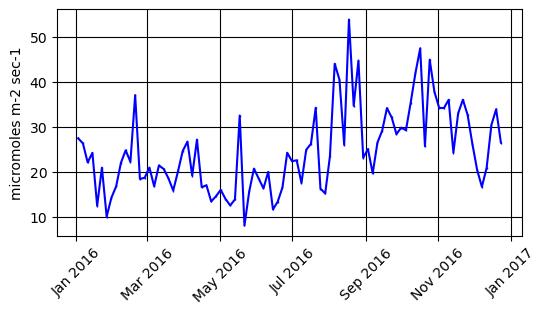

In [6]:
# Plot the result
print("Plot of area-average time series:")
ts_plot(dataset, ts_json, val_name='mean', units='micromoles m-2 sec-1')

## Time Averaged Map
Next we will issue an SDAP web service call to compute time averaged map.

In [7]:
# Compute time-averaged map using the SDAP/NEXUS web/HTTP interface
#
# Construct the URL
url = '{}/timeAvgMapSpark?ds={}&minLon={}&minLat={}&maxLon={}&maxLat={}&startTime={}&endTime={}'.\
    format(base_url, dataset, *bbox.bounds, 
           start_time.strftime(dt_format), end_time.strftime(dt_format))

# Display some information about the job
print(url); print()

# Query SDAP to compute the time averaged map
print("Waiting for response from SDAP on AWS...")
start = time.perf_counter()
tam_json = requests.get(url, verify=False).json()
print("Time averaged map took {} seconds".format(time.perf_counter() - start))

https://methane-sdap-sit.jpl.nasa.gov/nexus/timeAvgMapSpark?ds=M2AF_REGIONAL_LABASIN_CH4_fluxes&minLon=-118.9&minLat=33.4&maxLon=-116.5&maxLat=34.8&startTime=2016-01-01T00:00:00Z&endTime=2016-12-24T00:00:00Z

Waiting for response from SDAP on AWS...
Time averaged map took 1.5035901229130104 seconds


### JSON response
The SDAP web service calls return the result in `JSON`, a standard web services data
interchange format.  This makes it easy for another web service component to "consume" the SDAP output.
Let's view the JSON response.  It is long, so we'll show just the first few grid cells.

In [8]:
show_sdap_json(tam_json, nh=20, nt=10)

{'data': [[{'cnt': 0,
            'lat': 33.42499923706055,
            'lon': -118.8949966430664,
            'mean': -9999.0},
           {'cnt': 0,
            'lat': 33.42499923706055,
            'lon': -118.864990234375,
            'mean': -9999.0},
           {'cnt': 0,
            'lat': 33.42499923706055,
            'lon': -118.8349838256836,
            'mean': -9999.0},
           {'cnt': 0,
            'lat': 33.42499923706055,
            'lon': -118.80497741699219,
            'mean': -9999.0},
           {'cnt': 0,
            'lat': 33.42499923706055,
            'lon': -118.77497100830078,
            'mean': -9999.0},
		.
		.
		.

 'meta': {'bounds': {'east': -116.5,
                     'north': 34.8,
                     'south': 33.4,
                     'west': -118.9},
          'shortName': 'M2AF_REGIONAL_LABASIN_CH4_fluxes',
          'time': {'iso_start': '2016-01-01T00:00:00+0000',
                   'iso_stop': '2016-12-24T00:00:00+0000',
                

### Extract the actual data and plot the result
The actual map data is readily accessible for plotting.

Creating plot of the results.
This will take a minute.  Please wait...


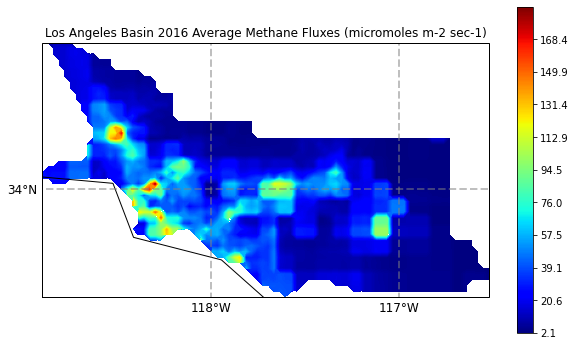

In [44]:
# Extract the actual output data
tam = tam_json["data"]

# Create a plot of the Time Averaged Map results
plot_map(tam, 
         title="Los Angeles Basin 2016 Average Methane Fluxes (micromoles m-2 sec-1)",
         grid_line_sep=1)

https://methane-sdap-sit.jpl.nasa.gov/nexus/timeSeriesSpark?ds=M2AF_GLOBAL_GOSAT_Emissions&minLon=-180.0&minLat=-90.0&maxLon=180.0&maxLat=90.0&startTime=2019-01-01T00:00:00Z&endTime=2019-12-31T00:00:00Z&seasonalFilter=false

https://methane-sdap-sit.jpl.nasa.gov/nexus/timeAvgMapSpark?ds=M2AF_GLOBAL_GOSAT_Emissions&minLon=-180.0&minLat=-90.0&maxLon=180.0&maxLat=90.0&startTime=2019-01-01T00:00:00Z&endTime=2019-12-31T00:00:00Z

Computing time series...
Area-averaged time series took 2.4577932209940627 seconds

Computing time averaged map...
Time averaged map took 1.512502679019235 seconds

Plot of area-average time series:


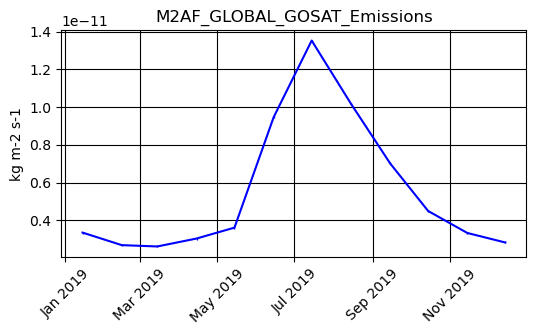

Creating plot of the results.
This will take a minute.  Please wait...


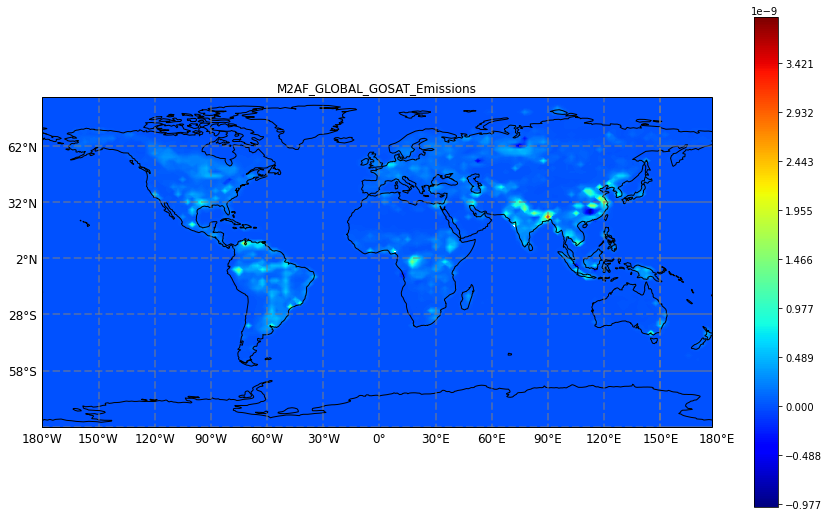

In [45]:
# Define dataset, units, bounding box and time period for analysis
dataset = "M2AF_GLOBAL_GOSAT_Emissions"
units = "kg m-2 s-1"
min_lon = -180; max_lon = 180
min_lat = -90; max_lat = 90
bbox = box(min_lon, min_lat, max_lon, max_lat)
start_time = datetime(2019, 1, 1)
end_time = datetime(2019, 12, 31)
compute_ts_and_tam(dataset, 
                   bbox, start_time, end_time, base_url=base_url, 
                   units=units, grid_line_sep=30, image_width=1500,
                   title=dataset)

https://methane-sdap-sit.jpl.nasa.gov/nexus/timeSeriesSpark?ds=M2AF_GLOBAL_LIVESTOCK_CH4_emission&minLon=-180.0&minLat=-90.0&maxLon=180.0&maxLat=90.0&startTime=2010-01-01T00:00:00Z&endTime=2018-12-31T00:00:00Z&seasonalFilter=false

https://methane-sdap-sit.jpl.nasa.gov/nexus/timeAvgMapSpark?ds=M2AF_GLOBAL_LIVESTOCK_CH4_emission&minLon=-180.0&minLat=-90.0&maxLon=180.0&maxLat=90.0&startTime=2010-01-01T00:00:00Z&endTime=2018-12-31T00:00:00Z

Computing time series...
Area-averaged time series took 0.25179903500247747 seconds

Computing time averaged map...
Time averaged map took 2.7648380110040307 seconds

The time series should only have 1 point representing the global mean for 2010-2018.
Here is the JSON response from SDAP:

{'data': [[{'cnt': 10800,
            'ds': 0,
            'iso_time': '2018-01-01T00:00:00+0000',
            'max': 0.16883011162281036,
            'mean': 0.00019375470583327115,
            'min': -0.003201365005224943,
            'std': 0.0034769230289166185,


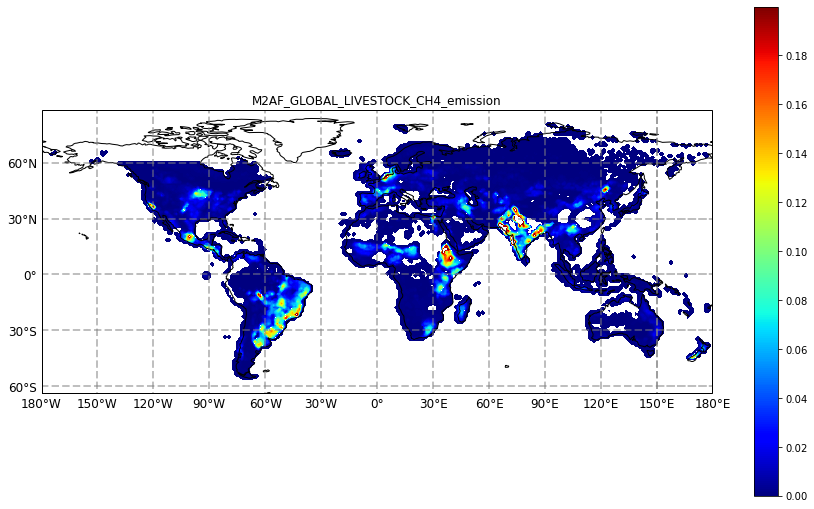

In [46]:
# Define dataset, units, bounding box and time period for analysis
#dataset = "M2AF_GLOBAL_COAL_CH4_emission"
#dataset = "M2AF_GLOBAL_WETLAND_CH4_emission"
dataset = "M2AF_GLOBAL_LIVESTOCK_CH4_emission"
units = "Tg_per_year"
min_lon = -180; max_lon = 180
min_lat = -90; max_lat = 90
#min_lon = 90; max_lon = 120
#min_lat = 30; max_lat = 60
bbox = box(min_lon, min_lat, max_lon, max_lat)
start_time = datetime(2010, 1, 1)
end_time = datetime(2018, 12, 31)
ts_json, tam_json = compute_ts_and_tam_no_plot(dataset, bbox, start_time, end_time, 
                                               base_url=base_url)

# Time series should only have 1 point representing 2010-2018.
print()
print("The time series should only have 1 point representing the global mean for 2010-2018.")
print("Here is the JSON response from SDAP:")
print()
pprint(ts_json)
print()

# Extract the actual output data
tam = tam_json["data"]

# Create a plot of the Time Averaged Map results
print("Here is the plot of the time averaged map over 2010-2018")
plot_map(tam, title=dataset, units=units, grid_line_sep=30, image_width=1500, vmin=0., vmax=0.2)

https://methane-sdap-sit.jpl.nasa.gov/nexus/timeSeriesSpark?ds=Global_Fuel_Exploitation_Inventory_GFEI_CH4_v2_coal&minLon=-125.0&minLat=25.0&maxLon=-65.0&maxLat=50.0&startTime=2010-01-01T00:00:00Z&endTime=2019-12-31T00:00:00Z&seasonalFilter=false

https://methane-sdap-sit.jpl.nasa.gov/nexus/timeAvgMapSpark?ds=Global_Fuel_Exploitation_Inventory_GFEI_CH4_v2_coal&minLon=-125.0&minLat=25.0&maxLon=-65.0&maxLat=50.0&startTime=2010-01-01T00:00:00Z&endTime=2019-12-31T00:00:00Z

Computing time series...
Area-averaged time series took 2.398426067084074 seconds

Computing time averaged map...
Time averaged map took 4.771751475986093 seconds

Plot of area-average time series:


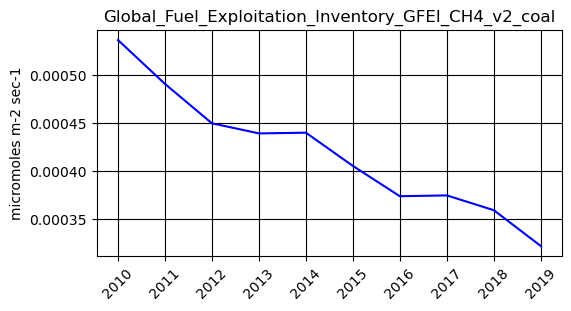

Creating plot of the results.
This will take a minute.  Please wait...


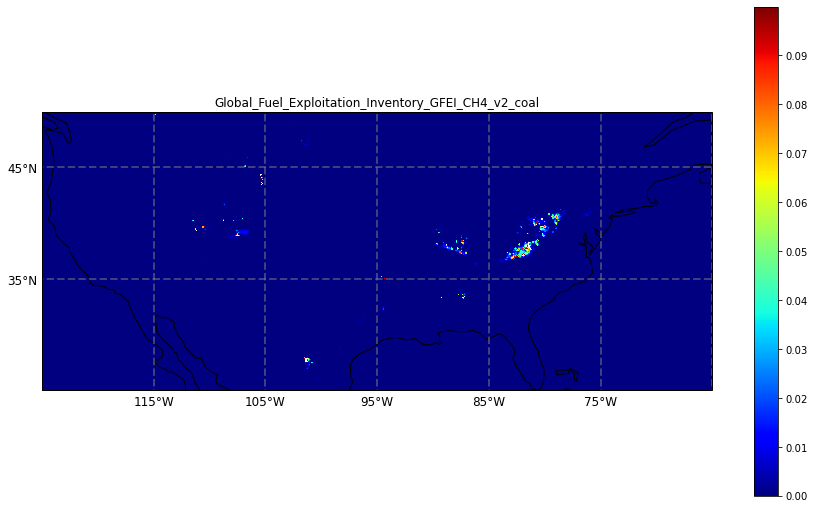

In [59]:
# Define dataset, units, bounding box and time period for analysis
dataset = "Global_Fuel_Exploitation_Inventory_GFEI_CH4_v2_coal"
units = "micromoles m-2 sec-1"
#min_lon = -180; max_lon = 180
#min_lat = -90; max_lat = 90
min_lon = -125; max_lon = -65
min_lat = 25; max_lat = 50
bbox = box(min_lon, min_lat, max_lon, max_lat)
start_time = datetime(2010, 1, 1)
end_time = datetime(2019, 12, 31)
compute_ts_and_tam(dataset, 
                   bbox, start_time, end_time, base_url=base_url, 
                   units=units, grid_line_sep=10, image_width=1500,
                   title=dataset, vmin=0., vmax=0.1)

https://methane-sdap-sit.jpl.nasa.gov/nexus/timeSeriesSpark?ds=Global_Fuel_Exploitation_Inventory_GFEI_CH4_v2_gas&minLon=-125.0&minLat=25.0&maxLon=-65.0&maxLat=50.0&startTime=2010-01-01T00:00:00Z&endTime=2019-12-31T00:00:00Z&seasonalFilter=false

https://methane-sdap-sit.jpl.nasa.gov/nexus/timeAvgMapSpark?ds=Global_Fuel_Exploitation_Inventory_GFEI_CH4_v2_gas&minLon=-125.0&minLat=25.0&maxLon=-65.0&maxLat=50.0&startTime=2010-01-01T00:00:00Z&endTime=2019-12-31T00:00:00Z

Computing time series...
Area-averaged time series took 2.3895105499541387 seconds

Computing time averaged map...
Time averaged map took 5.272015275084414 seconds

Plot of area-average time series:


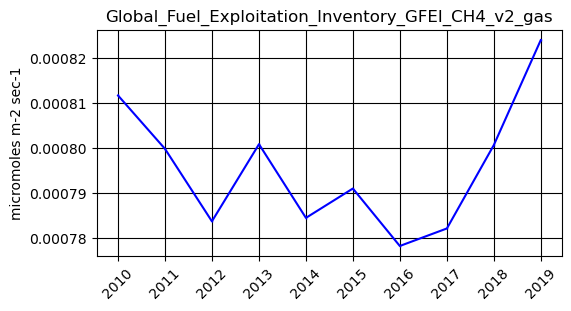

Creating plot of the results.
This will take a minute.  Please wait...


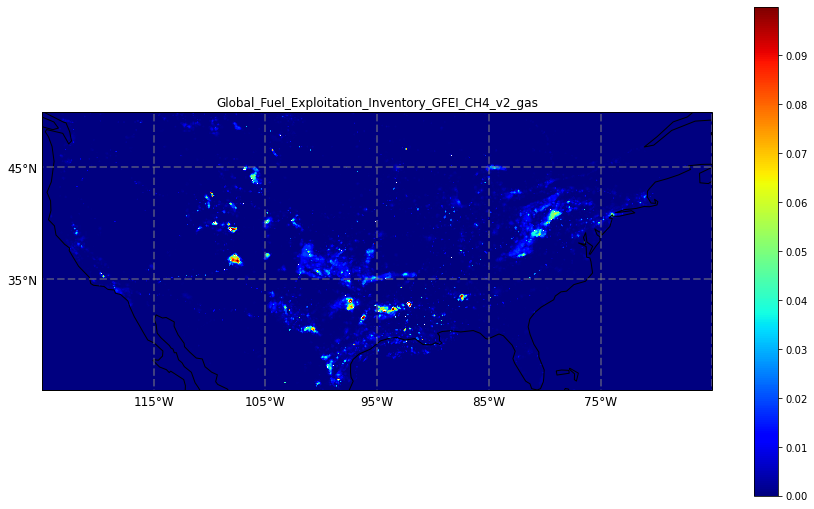

In [58]:
# Define dataset, units, bounding box and time period for analysis
dataset = "Global_Fuel_Exploitation_Inventory_GFEI_CH4_v2_gas"
units = "micromoles m-2 sec-1"
#min_lon = -180; max_lon = 180
#min_lat = -90; max_lat = 90
min_lon = -125; max_lon = -65
min_lat = 25; max_lat = 50
bbox = box(min_lon, min_lat, max_lon, max_lat)
start_time = datetime(2010, 1, 1)
end_time = datetime(2019, 12, 31)
compute_ts_and_tam(dataset, 
                   bbox, start_time, end_time, base_url=base_url, 
                   units=units, grid_line_sep=10, image_width=1500,
                   title=dataset, vmin=0., vmax=0.1)

https://methane-sdap-sit.jpl.nasa.gov/nexus/timeSeriesSpark?ds=Global_Fuel_Exploitation_Inventory_GFEI_CH4_v2_oil&minLon=-125.0&minLat=25.0&maxLon=-65.0&maxLat=50.0&startTime=2010-01-01T00:00:00Z&endTime=2019-12-31T00:00:00Z&seasonalFilter=false

https://methane-sdap-sit.jpl.nasa.gov/nexus/timeAvgMapSpark?ds=Global_Fuel_Exploitation_Inventory_GFEI_CH4_v2_oil&minLon=-125.0&minLat=25.0&maxLon=-65.0&maxLat=50.0&startTime=2010-01-01T00:00:00Z&endTime=2019-12-31T00:00:00Z

Computing time series...
Area-averaged time series took 2.5352181650232524 seconds

Computing time averaged map...
Time averaged map took 4.870440840953961 seconds

Plot of area-average time series:


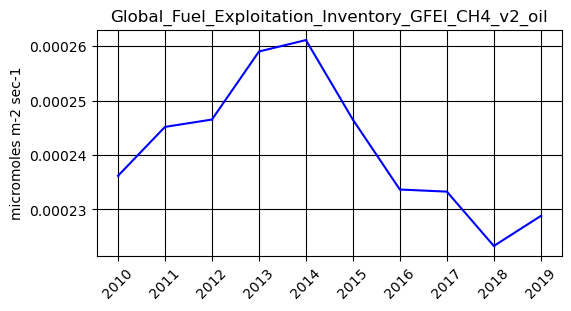

Creating plot of the results.
This will take a minute.  Please wait...


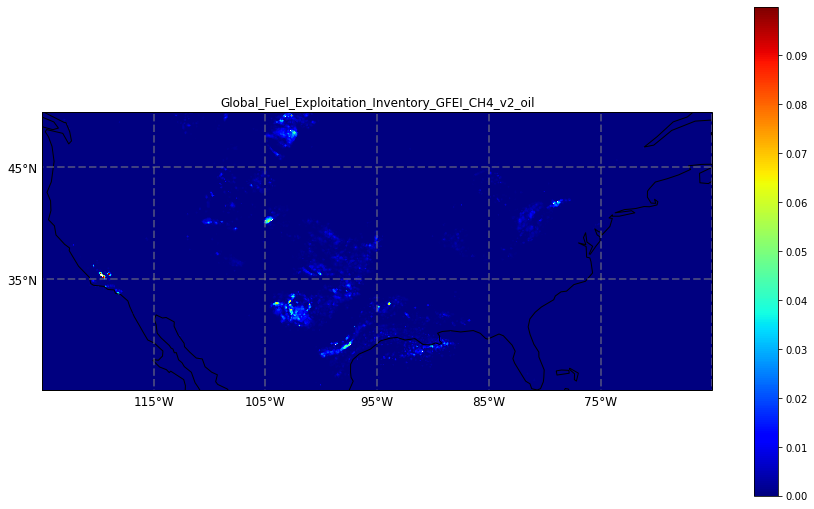

In [57]:
# Define dataset, units, bounding box and time period for analysis
dataset = "Global_Fuel_Exploitation_Inventory_GFEI_CH4_v2_oil"
units = "micromoles m-2 sec-1"
#min_lon = -180; max_lon = 180
#min_lat = -90; max_lat = 90
min_lon = -125; max_lon = -65
min_lat = 25; max_lat = 50
bbox = box(min_lon, min_lat, max_lon, max_lat)
start_time = datetime(2010, 1, 1)
end_time = datetime(2019, 12, 31)
compute_ts_and_tam(dataset, 
                   bbox, start_time, end_time, base_url=base_url, 
                   units=units, grid_line_sep=10, image_width=1500,
                   title=dataset, vmin=0., vmax=0.1)